In [1]:
!pip install --upgrade imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install dlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import cv2
from google.colab.patches import cv2_imshow
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import math
import matplotlib.pyplot as plt

**Mounted Drive**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Utils function**

In [6]:
def shape_to_np(shape, dtype="int"):
	# initialize the list of (x, y)-coordinates
	coords = np.zeros((68, 2), dtype=dtype)
	# loop over the 68 facial landmarks and convert them
	# to a 2-tuple of (x, y)-coordinates
	for i in range(0, 68):
		coords[i] = (shape.part(i).x, shape.part(i).y)
	# return the list of (x, y)-coordinates
	return coords

In [7]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/faceRecognition/dlib/shape_predictor_68_face_landmarks.dat')
predictor2 = dlib.shape_predictor('/content/drive/MyDrive/faceRecognition/dlib/shape_predictor_81_face_landmarks.dat')

In [8]:
def facial_landmarks(image):
    try:
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    except:
        grayscale_image = image

    # array of rectangles surrounding faces detected
    rectangles = detector(grayscale_image, 1)

    # If at least one face is detected, find its landmarks
    if len(rectangles) > 0:
        # Get 68 landmark points
        faceLandmarks = predictor(grayscale_image, rectangles[0])
        faceLandmarks = face_utils.shape_to_np(faceLandmarks)
        return faceLandmarks,rectangles
    else:
        return None

In [102]:
def align_face(image, eyePoints):
    # Get left eye & right eye coordinates
    leftEyeX,leftEyeY = eyePoints[0]
    rightEyeX, rightEyeY = eyePoints[1]

    # Calculate angle of rotation & origin point
    angle = math.atan( (leftEyeY - rightEyeY) / (leftEyeX - rightEyeX) ) * (180/math.pi)
    origin_point = tuple(np.array(image.shape[1::-1]) / 2)

    # Rotate using rotation matrix
    rot_mat = cv2.getRotationMatrix2D(origin_point, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    print(rot_mat)
    return result,rot_mat

In [145]:
def drawPoints(image, points, pointColor=(255,255,255), lineColor=(255,255,255), pointThickness=5, lineThickness=1):
    for i in points:
        x,y = i
        image = cv2.circle(image, (x,y), radius=0, color=pointColor, thickness=pointThickness)
    return image

In [136]:
def estimate_trans_bbox(face, input_size_x,input_size_y, s=2.0):
    face = face_utils.rect_to_bb(face)
    # face[2] = face[0] + face[2]
    # face[3] = face[1] + face[3]
    w = face[2]
    h = face[3]
    wc = int(face[0] + face[2]/2)
    hc = int(face[1] + face[2]/2)
    im_size = max(w, h)
    #size = int(im_size*1.2)
    scale_x = input_size_x / (max(w, h) * s)
    scale_y = input_size_y / (max(w, h) * s)
    M = [
        [scale_x, 0, input_size_x / 2 - wc * scale_x],
        [0, scale_y, input_size_y / 2 - hc * scale_y],
    ]
    M = np.array(M)
    return M

In [138]:
M_up = estimate_trans_bbox(rec[0],originalImage.shape[0],originalImage.shape[1])

150 98 154 155


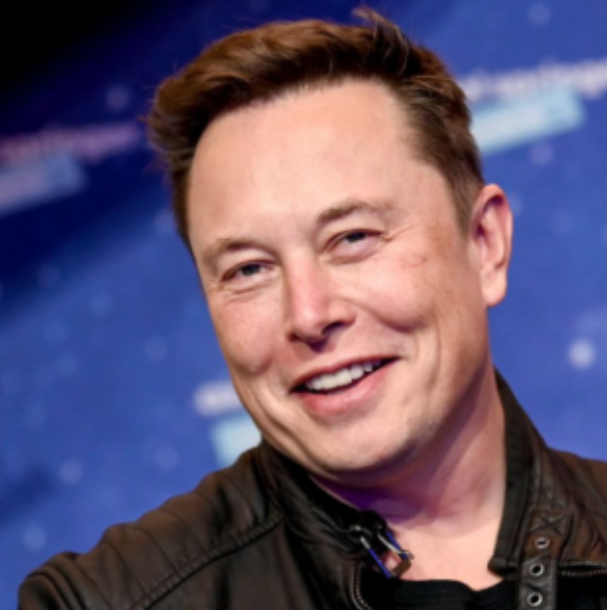

In [142]:
(x, y, w, h) = face_utils.rect_to_bb(rec[0])
print(x,y,w,h)

# x0 = x + w/2
# y0 = y + h/2

# M_up = np.float32([
# 	[1, 0, x],
# 	[0, 1, y]
# ])

M_down = np.float32([
  [1, 0, -x],
	[0, 1, -y]
])

originalImage = cv2.imread('/content/elonMusk.png')
# originalImage = cv2.cvtColor(originalImage,cv2.COLOR_BGR2RGB)

# new_eye_point = []
# for eye_point in eyePoints:
#   new_eye_point.append([eye_point[0] - w/2,eye_point[1] - h/2])

shifted = cv2.warpAffine(originalImage, M_up, (originalImage.shape[1], originalImage.shape[0]))

# shifted = cv2.warpAffine(shifted, M_down, (originalImage.shape[1], originalImage.shape[0]))

cv2_imshow(shifted)

[[  0.95782629  -0.28734789 100.44082753]
 [  0.28734789   0.95782629 -74.34710026]]


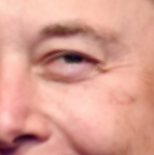

In [144]:
image,rot_mat = align_face(shifted, eyePoints)
image = cv2.warpAffine(image, M_down, (image.shape[1], image.shape[0]))
cv2_imshow(image[y:y + h, x:x + w])

In [98]:
originalImage.shape

(610, 607, 3)

In [114]:
M_up_test = np.float32([
	[1, 0, x],
	[0, 1, y],
  [0, 0, 1]
])

In [115]:
M_down_test = np.float32([
	[1, 0, -x],
	[0, 1, -y],
  [0, 0, 1]
])

In [123]:
import copy

rot_mat_test = copy.deepcopy(rot_mat)

In [128]:
rot_mat_test = np.concatenate((rot_mat,[0,0,1]),axis=0)
rot_mat_test

ValueError: ignored

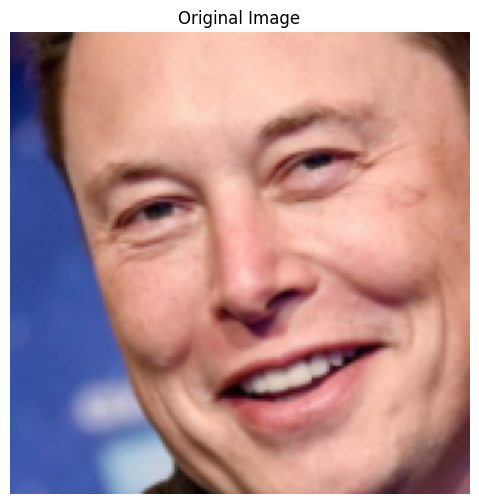

In [217]:
originalImage = cv2.imread('/content/elonMusk.png')
originalImage = cv2.cvtColor(originalImage,cv2.COLOR_BGR2RGB)

landmarks,rec = facial_landmarks(originalImage)
(x, y, w, h) = face_utils.rect_to_bb(rec[0])
originalImage = originalImage[y:y + h, x:x + w]
print(x,y,w,h)
plt.figure(figsize=(6,6))
plt.imshow(originalImage)
plt.axis("off")
plt.title("Original Image")
plt.show()

# if landmarks is not None:
#     # Find eye landmarks
#     eyePoints = (landmarks[39], landmarks[42]) # used for alignment

#     # Draw landmarks
#     # image = drawPoints(originalImage, landmarks)

#     # Align face
#     image = align_face(originalImage, eyePoints)

#     plt.figure(figsize=(6,6))
#     plt.imshow(image)
#     plt.axis("off")
#     plt.title("Processed Image")
#     plt.show()

In [214]:
w

223

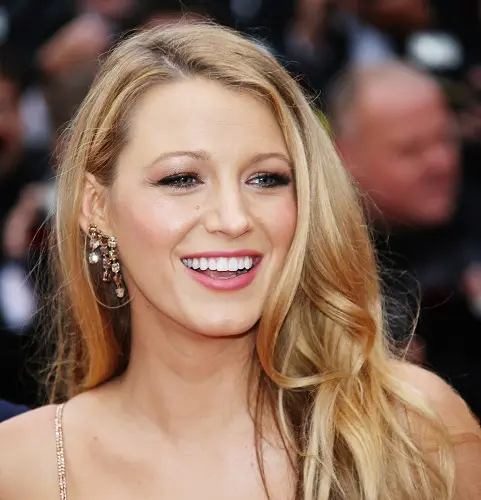

In [236]:
originalImage = cv2.imread('/content/blackLively.jpg')

landmarks,rec = facial_landmarks(originalImage)
(x, y, w, h) = face_utils.rect_to_bb(rec[0])
a = [landmarks[17],landmarks[26],landmarks[33],landmarks[4],landmarks[12]]

# image = drawPoints(originalImage, a)
cv2_imshow(originalImage)

In [237]:
import cv2
import numpy as np
from skimage import transform as trans

__file__ = 'test'

# reference facial points, a list of coordinates (x,y)
REFERENCE_FACIAL_POINTS = [
    [30.29459953, 51.69630051],
    [65.53179932, 51.50139999],
    [48.02519989, 71.73660278],
    [33.54930115, 92.3655014],
    [62.72990036, 92.20410156]
]

DEFAULT_CROP_SIZE = (96, 112)


class FaceWarpException(Exception):
    def __str__(self):
        return 'In File {}:{}'.format(
            __file__, super.__str__(self))


def get_reference_facial_points(output_size=None,
                                inner_padding_factor=0.0,
                                outer_padding=(0, 0),
                                default_square=False):
    tmp_5pts = np.array(REFERENCE_FACIAL_POINTS)
    tmp_crop_size = np.array(DEFAULT_CROP_SIZE)

    # 0) make the inner region a square
    if default_square:
        size_diff = max(tmp_crop_size) - tmp_crop_size
        tmp_5pts += size_diff / 2
        tmp_crop_size += size_diff

    # print('---> default:')
    # print('              crop_size = ', tmp_crop_size)
    # print('              reference_5pts = ', tmp_5pts)

    if (output_size and
            output_size[0] == tmp_crop_size[0] and
            output_size[1] == tmp_crop_size[1]):
        print('output_size == DEFAULT_CROP_SIZE {}: return default reference points'.format(tmp_crop_size))
        return tmp_5pts

    if (inner_padding_factor == 0 and
            outer_padding == (0, 0)):
        if output_size is None:
            print('No paddings to do: return default reference points')
            return tmp_5pts
        else:
            raise FaceWarpException(
                'No paddings to do, output_size must be None or {}'.format(tmp_crop_size))

    # check output size
    if not (0 <= inner_padding_factor <= 1.0):
        raise FaceWarpException('Not (0 <= inner_padding_factor <= 1.0)')

    if ((inner_padding_factor > 0 or outer_padding[0] > 0 or outer_padding[1] > 0)
            and output_size is None):
        output_size = tmp_crop_size * \
                      (1 + inner_padding_factor * 2).astype(np.int32)
        output_size += np.array(outer_padding)
        print('              deduced from paddings, output_size = ', output_size)

    if not (outer_padding[0] < output_size[0]
            and outer_padding[1] < output_size[1]):
        raise FaceWarpException('Not (outer_padding[0] < output_size[0]'
                                'and outer_padding[1] < output_size[1])')

    # 1) pad the inner region according inner_padding_factor
    # print('---> STEP1: pad the inner region according inner_padding_factor')
    if inner_padding_factor > 0:
        size_diff = tmp_crop_size * inner_padding_factor * 2
        tmp_5pts += size_diff / 2
        tmp_crop_size += np.round(size_diff).astype(np.int32)

    # print('              crop_size = ', tmp_crop_size)
    # print('              reference_5pts = ', tmp_5pts)

    # 2) resize the padded inner region
    # print('---> STEP2: resize the padded inner region')
    size_bf_outer_pad = np.array(output_size) - np.array(outer_padding) * 2
    # print('              crop_size = ', tmp_crop_size)
    # print('              size_bf_outer_pad = ', size_bf_outer_pad)

    if size_bf_outer_pad[0] * tmp_crop_size[1] != size_bf_outer_pad[1] * tmp_crop_size[0]:
        raise FaceWarpException('Must have (output_size - outer_padding)'
                                '= some_scale * (crop_size * (1.0 + inner_padding_factor)')

    scale_factor = size_bf_outer_pad[0].astype(np.float32) / tmp_crop_size[0]
    # print('              resize scale_factor = ', scale_factor)
    tmp_5pts = tmp_5pts * scale_factor
    #    size_diff = tmp_crop_size * (scale_factor - min(scale_factor))
    #    tmp_5pts = tmp_5pts + size_diff / 2
    tmp_crop_size = size_bf_outer_pad
    # print('              crop_size = ', tmp_crop_size)
    # print('              reference_5pts = ', tmp_5pts)

    # 3) add outer_padding to make output_size
    reference_5point = tmp_5pts + np.array(outer_padding)
    tmp_crop_size = output_size
    # print('---> STEP3: add outer_padding to make output_size')
    # print('              crop_size = ', tmp_crop_size)
    # print('              reference_5pts = ', tmp_5pts)
    #
    # print('===> end get_reference_facial_points\n')

    return reference_5point


def get_affine_transform_matrix(src_pts, dst_pts):
    tfm = np.float32([[1, 0, 0], [0, 1, 0]])
    n_pts = src_pts.shape[0]
    ones = np.ones((n_pts, 1), src_pts.dtype)
    src_pts_ = np.hstack([src_pts, ones])
    dst_pts_ = np.hstack([dst_pts, ones])

    A, res, rank, s = np.linalg.lstsq(src_pts_, dst_pts_)

    if rank == 3:
        tfm = np.float32([
            [A[0, 0], A[1, 0], A[2, 0]],
            [A[0, 1], A[1, 1], A[2, 1]]
        ])
    elif rank == 2:
        tfm = np.float32([
            [A[0, 0], A[1, 0], 0],
            [A[0, 1], A[1, 1], 0]
        ])

    return tfm


def warp_and_crop_face(src_img,
                       facial_pts,
                       reference_pts=None,
                       crop_size=(96, 112),
                       align_type='smilarity'):
    if reference_pts is None:
        if crop_size[0] == 96 and crop_size[1] == 112:
            reference_pts = REFERENCE_FACIAL_POINTS
        else:
            default_square = False
            inner_padding_factor = 0
            outer_padding = (0, 0)
            output_size = crop_size

            reference_pts = get_reference_facial_points(output_size,
                                                        inner_padding_factor,
                                                        outer_padding,
                                                        default_square)

    ref_pts = np.float32(reference_pts)
    ref_pts_shp = ref_pts.shape
    if max(ref_pts_shp) < 3 or min(ref_pts_shp) != 2:
        raise FaceWarpException(
            'reference_pts.shape must be (K,2) or (2,K) and K>2')

    if ref_pts_shp[0] == 2:
        ref_pts = ref_pts.T

    src_pts = np.float32(facial_pts)
    src_pts_shp = src_pts.shape
    if max(src_pts_shp) < 3 or min(src_pts_shp) != 2:
        raise FaceWarpException(
            'facial_pts.shape must be (K,2) or (2,K) and K>2')

    if src_pts_shp[0] == 2:
        src_pts = src_pts.T

    if src_pts.shape != ref_pts.shape:
        raise FaceWarpException(
            'facial_pts and reference_pts must have the same shape')

    if align_type == 'cv2_affine':
        tfm = cv2.getAffineTransform(src_pts[0:3], ref_pts[0:3])
    #        print('cv2.getAffineTransform() returns tfm=\n' + str(tfm))
    elif align_type == 'affine':
        tfm = get_affine_transform_matrix(src_pts, ref_pts)
    #        print('get_affine_transform_matrix() returns tfm=\n' + str(tfm))
    else:
        # tfm = get_similarity_transform_for_cv2(src_pts, ref_pts)
        tform = trans.SimilarityTransform()
        tform.estimate(src_pts, ref_pts)
        tfm = tform.params[0:2, :]

    face_img = cv2.warpAffine(src_img, tfm, (crop_size[0], crop_size[1]))

    return face_img

In [242]:
img = warp_and_crop_face(originalImage,a,reference_pts=None,crop_size=(96,112),align_type='')

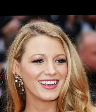

In [244]:
cv2_imshow(img)